The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install d2l==1.0.3


# Convolutional Neural Networks (LeNet)
:label:`sec_lenet`

We now have all the ingredients required to assemble
a fully-functional CNN.
In our earlier encounter with image data, we applied
a linear model with softmax regression (:numref:`sec_softmax_scratch`)
and an MLP (:numref:`sec_mlp-implementation`)
to pictures of clothing in the Fashion-MNIST dataset.
To make such data amenable we first flattened each image from a $28\times28$ matrix
into a fixed-length $784$-dimensional vector,
and thereafter processed them in fully connected layers.
Now that we have a handle on convolutional layers,
we can retain the spatial structure in our images.
As an additional benefit of replacing fully connected layers with convolutional layers,
we will enjoy more parsimonious models that require far fewer parameters.

In this section, we will introduce *LeNet*,
among the first published CNNs
to capture wide attention for its performance on computer vision tasks.
The model was introduced by (and named for) Yann LeCun,
then a researcher at AT&T Bell Labs,
for the purpose of recognizing handwritten digits in images :cite:`LeCun.Bottou.Bengio.ea.1998`.
This work represented the culmination
of a decade of research developing the technology;
LeCun's team published the first study to successfully
train CNNs via backpropagation :cite:`LeCun.Boser.Denker.ea.1989`.

At the time LeNet achieved outstanding results
matching the performance of support vector machines,
then a dominant approach in supervised learning, achieving an error rate of less than 1% per digit.
LeNet was eventually adapted to recognize digits
for processing deposits in ATM machines.
To this day, some ATMs still run the code
that Yann LeCun and his colleague Leon Bottou wrote in the 1990s!


In [2]:
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt
import numpy as np

## LeNet

At a high level, (**LeNet (LeNet-5) consists of two parts:
(i) a convolutional encoder consisting of two convolutional layers; and
(ii) a dense block consisting of three fully connected layers**).
The architecture is summarized in :numref:`img_lenet`.

![Data flow in LeNet. The input is a handwritten digit, the output is a probability over 10 possible outcomes.](http://d2l.ai/_images/lenet.svg)
:label:`img_lenet`

The basic units in each convolutional block
are a convolutional layer, a sigmoid activation function,
and a subsequent average pooling operation.
Note that while ReLUs and max-pooling work better,
they had not yet been discovered.
Each convolutional layer uses a $5\times 5$ kernel
and a sigmoid activation function.
These layers map spatially arranged inputs
to a number of two-dimensional feature maps, typically
increasing the number of channels.
The first convolutional layer has 6 output channels,
while the second has 16.
Each $2\times2$ pooling operation (stride 2)
reduces dimensionality by a factor of $4$ via spatial downsampling.
The convolutional block emits an output with shape given by
(batch size, number of channel, height, width).

In order to pass output from the convolutional block
to the dense block,
we must flatten each example in the minibatch.
In other words, we take this four-dimensional input and transform it
into the two-dimensional input expected by fully connected layers:
as a reminder, the two-dimensional representation that we desire uses the first dimension to index examples in the minibatch
and the second to give the flat vector representation of each example.
LeNet's dense block has three fully connected layers,
with 120, 84, and 10 outputs, respectively.
Because we are still performing classification,
the 10-dimensional output layer corresponds
to the number of possible output classes.

While getting to the point where you truly understand
what is going on inside LeNet may have taken a bit of work,
we hope that the following code snippet will convince you
that implementing such models with modern deep learning frameworks
is remarkably simple.
We need only to instantiate a `Sequential` block
and chain together the appropriate layers,
using Xavier initialization as
introduced in :numref:`subsec_xavier`.


In [3]:
def init_cnn(module):  #@save
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

In [6]:
class LeNet(d2l.Classifier):  #@save
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

We have taken some liberty in the reproduction of LeNet insofar as we have replaced the Gaussian activation layer by
a softmax layer. This greatly simplifies the implementation, not least due to the
fact that the Gaussian decoder is rarely used nowadays. Other than that, this network matches
the original LeNet-5 architecture.


Let's see what happens inside the network. By passing a
single-channel (black and white)
$28 \times 28$ image through the network
and printing the output shape at each layer,
we can [**inspect the model**] to ensure
that its operations line up with
what we expect from :numref:`img_lenet_vert`.


![Compressed notation for LeNet-5.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/lenet-vert.svg?raw=1)
:label:`img_lenet_vert`


In [7]:
@d2l.add_to_class(d2l.Classifier)
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()
model.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


Note that the height and width of the representation
at each layer throughout the convolutional block
is reduced (compared with the previous layer).
The first convolutional layer uses two pixels of padding
to compensate for the reduction in height and width
that would otherwise result from using a $5 \times 5$ kernel.
As an aside, the image size of $28 \times 28$ pixels in the original
MNIST OCR dataset is a result of *trimming* two pixel rows (and columns) from the
original scans that measured $32 \times 32$ pixels. This was done primarily to
save space (a 30% reduction) at a time when megabytes mattered.

In contrast, the second convolutional layer forgoes padding,
and thus the height and width are both reduced by four pixels.
As we go up the stack of layers,
the number of channels increases layer-over-layer
from 1 in the input to 6 after the first convolutional layer
and 16 after the second convolutional layer.
However, each pooling layer halves the height and width.
Finally, each fully connected layer reduces dimensionality,
finally emitting an output whose dimension
matches the number of classes.


## Training

Now that we have implemented the model,
let's [**run an experiment to see how the LeNet-5 model fares on Fashion-MNIST**].

While CNNs have fewer parameters,
they can still be more expensive to compute
than similarly deep MLPs
because each parameter participates in many more
multiplications.
If you have access to a GPU, this might be a good time
to put it into action to speed up training.
Note that
the `d2l.Trainer` class takes care of all details.
By default, it initializes the model parameters on the
available devices.
Just as with MLPs, our loss function is cross-entropy,
and we minimize it via minibatch stochastic gradient descent.


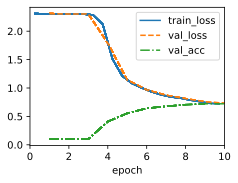

In [8]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

In [10]:
y_hat = model(data.val.data.type(torch.float32).unsqueeze(dim=1).cuda())
model.accuracy(y_hat,data.val.targets.cuda()).item()

0.5030999779701233

## Summary

We have made significant progress in this chapter. We moved from the MLPs of the 1980s to the CNNs of the 1990s and early 2000s. The architectures proposed, e.g., in the form of LeNet-5 remain meaningful, even to this day. It is worth comparing the error rates on Fashion-MNIST achievable with LeNet-5 both to the very best possible with MLPs (:numref:`sec_mlp-implementation`) and those with significantly more advanced architectures such as ResNet (:numref:`sec_resnet`). LeNet is much more similar to the latter than to the former. One of the primary differences, as we shall see, is that greater amounts of computation enabled significantly more complex architectures.

A second difference is the relative ease with which we were able to implement LeNet. What used to be an engineering challenge worth months of C++ and assembly code, engineering to improve SN, an early Lisp-based deep learning tool :cite:`Bottou.Le-Cun.1988`, and finally experimentation with models can now be accomplished in minutes. It is this incredible productivity boost that has democratized deep learning model development tremendously. In the next chapter we will journey down this rabbit to hole to see where it takes us.

## Exercises

1. Let's modernize LeNet. Implement and test the following changes:
    1. Replace average pooling with max-pooling.
    1. Replace the softmax layer with ReLU.
1. Try to change the size of the LeNet style network to improve its accuracy in addition to max-pooling and ReLU.
    1. Adjust the convolution window size.
    1. Adjust the number of output channels.
    1. Adjust the number of convolution layers.
    1. Adjust the number of fully connected layers.
    1. Adjust the learning rates and other training details (e.g., initialization and number of epochs).
1. Try out the improved network on the original MNIST dataset.
1. Display the activations of the first and second layer of LeNet for different inputs (e.g., sweaters and coats).
1. What happens to the activations when you feed significantly different images into the network (e.g., cats, cars, or even random noise)?


[Discussions](https://discuss.d2l.ai/t/74)


### Exercise 1:

In [13]:
class MaxLeNet(d2l.Classifier):
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

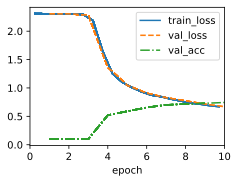

In [14]:
max_model = MaxLeNet(lr=0.1)
max_model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(max_model, data)

In [15]:
y_hat = max_model(data.val.data.type(torch.float32).unsqueeze(dim=1).cuda())
max_model.accuracy(y_hat,data.val.targets.cuda()).item()

0.585099995136261

In [14]:
class MaxReluLeNet(d2l.Classifier):
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes))

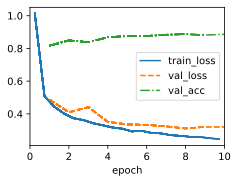

In [15]:
max_relu_model = MaxReluLeNet(lr=0.1)
max_relu_model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(max_relu_model, data)

In [16]:
y_hat = max_relu_model(data.val.data.type(torch.float32).unsqueeze(dim=1).cuda())
base_model_acc = max_relu_model.accuracy(y_hat,data.val.targets.cuda()).item()
base_model_acc

0.8377999663352966

### Exercise 2:

In [4]:
class GeneralLeNet(d2l.Classifier):
    """The LeNet-5 model."""
    def __init__(self, conv_layers, connected_layers, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()

        layers = []
        for conv_layer in conv_layers:
            layers.append(nn.LazyConv2d(**conv_layer))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        layers.append(nn.Flatten())

        for connected_layer in connected_layers:
            layers.append(nn.LazyLinear(connected_layer))
            layers.append(nn.ReLU())

        layers.append(nn.LazyLinear(num_classes))
        self.net = nn.Sequential(*layers)

#### 2.1.

In [29]:
window_sizes = [1, 2, 3, 7, 9]
conv_layers = []
for window_size in window_sizes:
    conv_layers.append([
        dict(out_channels=6, kernel_size=window_size, padding=window_size//2),
        dict(out_channels=16, kernel_size=window_size, padding=0),
    ])

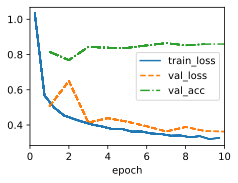

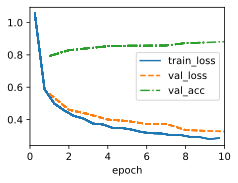

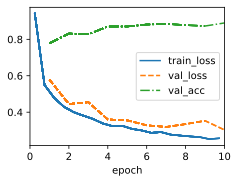

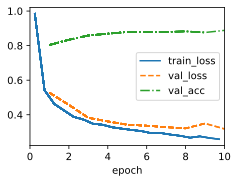

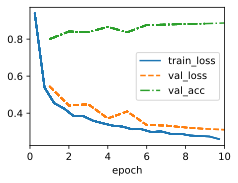

In [21]:
accuracies = []

for conv_layer in conv_layers:
  print(conv_layer)
  model = GeneralLeNet(conv_layer, [120, 84], lr=0.1)
  model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
  trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
  trainer.fit(model, data)
  y_hat = model(data.val.data.type(torch.float32).unsqueeze(dim=1).cuda())
  accuracies.append(model.accuracy(y_hat,data.val.targets.cuda()).item())

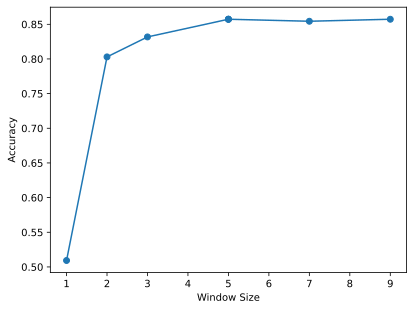

In [28]:
window_sizes.insert(3, 5)
accuracies.insert(3, max_relu_model.accuracy(y_hat,data.val.targets.cuda()).item())
plt.plot(window_sizes, accuracies, marker='o')
plt.xlabel('Window Size')
plt.ylabel('Accuracy')
plt.show()

#### 2.2.

In [34]:
output_channels = [[2, 4], [4, 8], [16, 32], [32, 64], [64, 128]]
conv_layers = []
for first, second in output_channels:
    conv_layers.append([
        dict(out_channels=first, kernel_size=5, padding=2),
        dict(out_channels=second, kernel_size=5, padding=0),
    ])

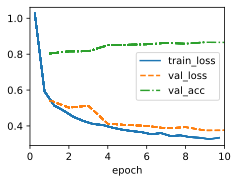

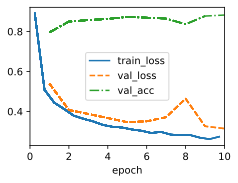

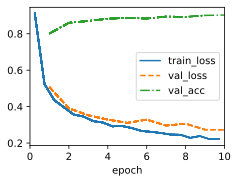

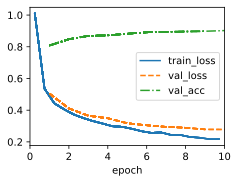

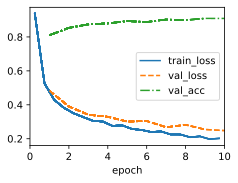

In [35]:
accuracies = []

for conv_layer in conv_layers:
  print(conv_layer)
  model = GeneralLeNet(conv_layer, [120, 84], lr=0.1)
  model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
  trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
  trainer.fit(model, data)
  y_hat = model(data.val.data.type(torch.float32).unsqueeze(dim=1).cuda())
  accuracies.append(model.accuracy(y_hat,data.val.targets.cuda()).item())

In [36]:
print(accuracies)

[0.8423999547958374, 0.7877999544143677, 0.861299991607666, 0.8517999649047852, 0.8574999570846558]


#### 2.3.

In [12]:
output_channels = [[(6, 5, 0)], [(6, 5, 2), (16, 5, 2), (32, 5, 0)], [(6, 5, 2), (16, 5, 2), (32, 5, 2), (64, 2, 0)]]
conv_layers = []
for output_channel in output_channels:
  tmp = []
  for num_outputs, window_size, padding in output_channel:
    tmp.append(
        dict(out_channels=num_outputs, kernel_size=window_size, padding=padding)
    )

  conv_layers.append(tmp)

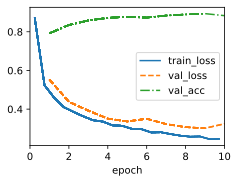

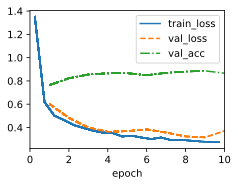

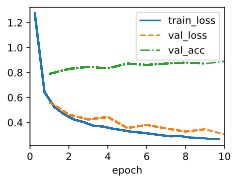

In [13]:
accuracies = []

for conv_layer in conv_layers:
  print(conv_layer)
  model = GeneralLeNet(conv_layer, [120, 84], lr=0.1)
  model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
  trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
  trainer.fit(model, data)
  y_hat = model(data.val.data.type(torch.float32).unsqueeze(dim=1).cuda())
  accuracies.append(model.accuracy(y_hat,data.val.targets.cuda()).item())

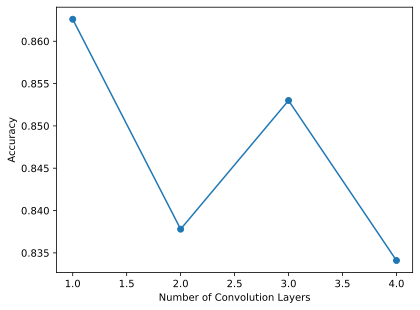

In [17]:
num_layers = [1, 2, 3, 4]
accuracies.insert(1, base_model_acc)
plt.plot(num_layers, accuracies, marker='o')
plt.xlabel('Number of Convolution Layers')
plt.ylabel('Accuracy')
plt.show()

#### 2.4.

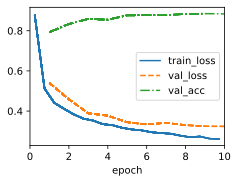

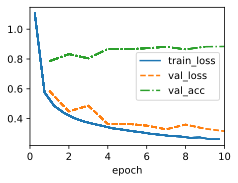

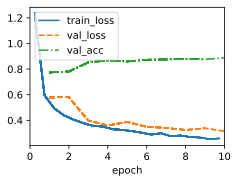

In [12]:
conv_layer = [
  dict(out_channels=6, kernel_size=5, padding=2),
  dict(out_channels=16, kernel_size=5, padding=0),
]
connected_layers = [[120], [120, 84, 40], [120, 84, 40, 20]]
accuracies = []

for connected_layer in connected_layers:
  print(conv_layer, connected_layer)
  model = GeneralLeNet(conv_layer, connected_layer, lr=0.1)
  model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
  trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
  trainer.fit(model, data)
  y_hat = model(data.val.data.type(torch.float32).unsqueeze(dim=1).cuda())
  accuracies.append(model.accuracy(y_hat,data.val.targets.cuda()).item())

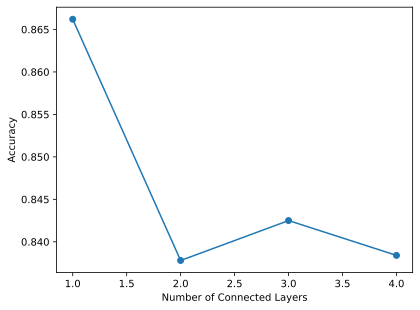

In [15]:
num_connected_layers = [1, 2, 3, 4]
accuracies.insert(1, base_model_acc)
plt.plot(num_connected_layers, accuracies, marker='o')
plt.xlabel('Number of Connected Layers')
plt.ylabel('Accuracy')
plt.show()

#### 2.5.

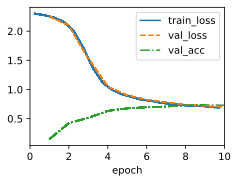

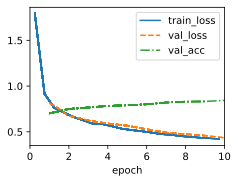

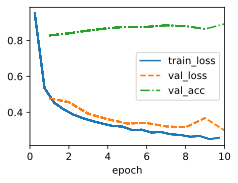

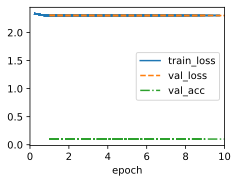

In [27]:
lrs = [0.001, 0.01, 0.1, 1]
conv_layer = [
  dict(out_channels=6, kernel_size=5, padding=2),
  dict(out_channels=16, kernel_size=5, padding=0),
]
accuracies = []

for lr in lrs:
  model = GeneralLeNet(conv_layer, [120, 84], lr=lr)
  model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
  trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
  trainer.fit(model, data)
  y_hat = model(data.val.data.type(torch.float32).unsqueeze(dim=1).cuda())
  accuracies.append(model.accuracy(y_hat,data.val.targets.cuda()).item())

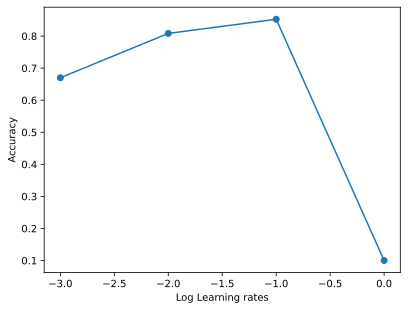

In [36]:
plt.plot(np.log10(lrs), accuracies, marker='o')
plt.xlabel('Log Learning rates')
plt.ylabel('Accuracy')
plt.show()

### Exercise 3:

In [16]:
import torchvision
from torchvision import transforms


class MNIST(d2l.DataModule):
    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([transforms.Resize(resize),
                                    transforms.ToTensor()])
        self.train = torchvision.datasets.MNIST(
            root=self.root, train=True, transform=trans, download=True)
        self.val = torchvision.datasets.MNIST(
            root=self.root, train=False, transform=trans, download=True)

    def get_dataloader(self, train):
      data = self.train if train else self.val
      return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                        num_workers=self.num_workers)

    def visualize(self, batch, nrows=1, ncols=8, labels=[]):
        X, y = batch
        if not labels:
            labels = self.text_labels(y)
        d2l.show_images(X.squeeze(1), nrows, ncols, titles=labels)


In [18]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = MNIST(batch_size=128)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.5MB/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 433kB/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.98MB/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.15MB/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



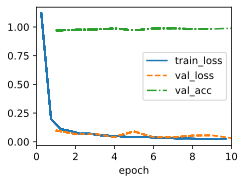

In [21]:
conv_layer = [
  dict(out_channels=6, kernel_size=5, padding=2),
  dict(out_channels=16, kernel_size=5, padding=2),
  dict(out_channels=32, kernel_size=5, padding=0),
]

model = GeneralLeNet(conv_layer, [120, 84], lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

In [23]:
y_hat = model(data.val.data.type(torch.float32).unsqueeze(dim=1).cuda())
model.accuracy(y_hat,data.val.targets.cuda()).item()

0.9898999929428101

### Exercise 4:

In [159]:
fashionData = d2l.FashionMNIST(batch_size=128)

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

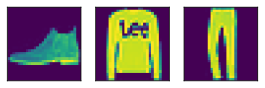

In [160]:
pic = fashionData.val.data[:3,:].type(torch.float32).unsqueeze(dim=1)
d2l.show_images(pic.squeeze(),1,3)

In [161]:
def plot_feature_maps(activations, num_images=3, num_filters=6, rows=2, cols=3, img_size=1.2):
    for img_idx in range(num_images):
        act = activations[img_idx]  # Extract feature maps for one image
        fig, axes = plt.subplots(rows, cols, figsize=(cols * img_size, rows * img_size))

        for i, ax in enumerate(axes.flat):
            if i < num_filters:
                ax.imshow(act[i])
            ax.axis("off")

        plt.subplots_adjust(wspace=0.1, hspace=0.1)
        plt.show()

In [162]:
activations = {}
def hook_fn(module, input, output):
    activations[module] = output

In [163]:
model.net[0].register_forward_hook(hook_fn)
model.net[3].register_forward_hook(hook_fn)

In [164]:
model(pic)

first_layer_activations = activations[model.net[0]].cpu().detach()
second_layer_activations = activations[model.net[3]].cpu().detach()

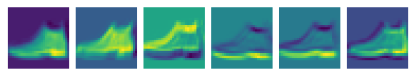

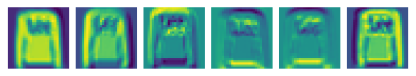

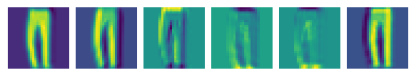

In [165]:
plot_feature_maps(first_layer_activations, num_filters=6, rows=1, cols=6)

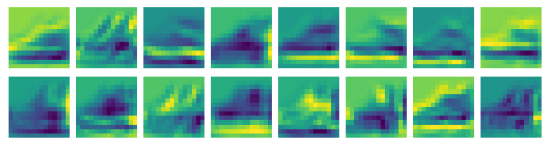

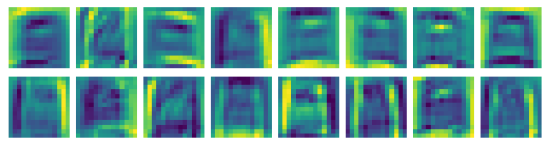

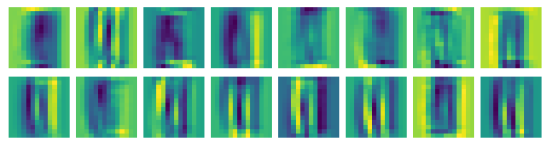

In [167]:
plot_feature_maps(second_layer_activations, num_filters=16, rows=2, cols=8)

### Exercise 5:

In [72]:
class CIFAR10(d2l.DataModule):
    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([transforms.Resize(resize),
                                    transforms.ToTensor()])
        self.train = torchvision.datasets.CIFAR10(
            root=self.root, train=True, transform=trans, download=True)
        self.val = torchvision.datasets.CIFAR10(
            root=self.root, train=False, transform=trans, download=True)

    def get_dataloader(self, train):
      data = self.train if train else self.val
      return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                        num_workers=self.num_workers)

    def visualize(self, batch, nrows=1, ncols=8, labels=[]):
        X, y = batch
        if not labels:
            labels = self.text_labels(y)
        d2l.show_images(X.squeeze(1), nrows, ncols, titles=labels)

In [168]:
cifar10 = CIFAR10(batch_size=128)

Files already downloaded and verified
Files already downloaded and verified


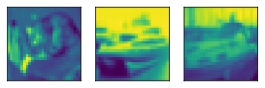

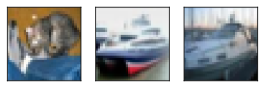

In [181]:
pic = cifar10.val.data[:3]
resize_transform = transforms.Resize((28, 28))
pic_resized = resize_transform(torch.tensor(pic).type(torch.float32).transpose(dim0 = 1, dim1 = 3).mean(1, True)) # RGB to grayscale
d2l.show_images(pic_resized.transpose(dim0=1, dim1=3), 1, 3)
d2l.show_images(pic, 1, 3)
plt.show()

In [182]:
model(pic_resized)

first_layer_activations = activations[model.net[0]].cpu().detach()
second_layer_activations = activations[model.net[3]].cpu().detach()

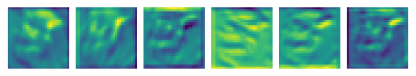

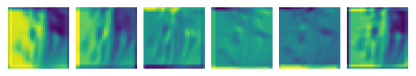

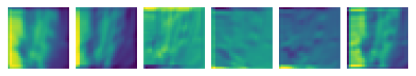

In [183]:
plot_feature_maps(first_layer_activations, num_filters=6, rows=1, cols=6)

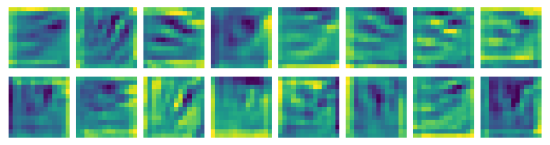

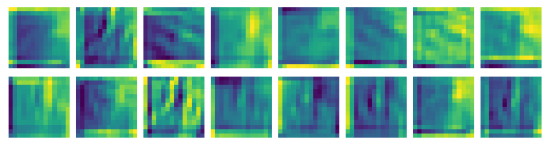

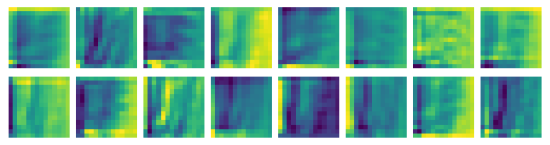

In [185]:
plot_feature_maps(second_layer_activations, num_filters=16, rows=2, cols=8)

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

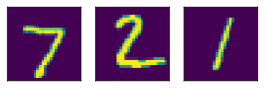

In [188]:
pic = data.val.data[:3,:].type(torch.float32).unsqueeze(dim=1)
d2l.show_images(pic.squeeze(),1,3)

In [189]:
model(pic)

first_layer_activations = activations[model.net[0]].cpu().detach()
second_layer_activations = activations[model.net[3]].cpu().detach()

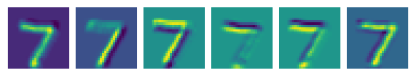

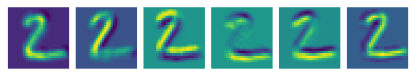

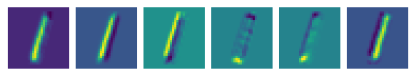

In [191]:
plot_feature_maps(first_layer_activations, num_filters=6, rows=1, cols=6)

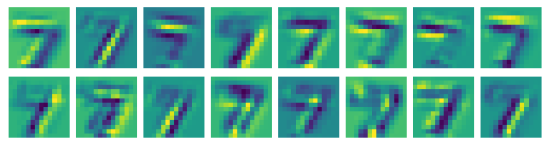

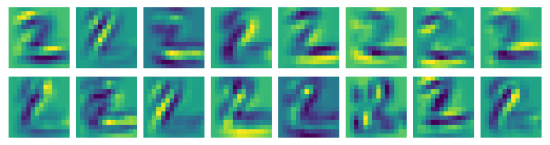

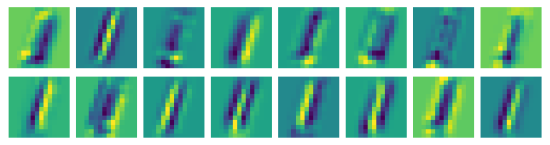

In [190]:
plot_feature_maps(second_layer_activations, num_filters=16, rows=2, cols=8)